In [85]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jpx-tokyo-stock-exchange-prediction/stock_list.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/options.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/financials.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/secondary_stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/trades.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/jpx-tokyo-stock-exchange-prediction/jpx_tokyo_market_prediction/__init__.py
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/stock_fin_spec.csv
/kaggle/input/jpx-tokyo-stock-exchange-prediction/data_specifications/trades_spec.csv
/kaggle/input/jpx-tokyo-stock-

In [86]:
import numpy as np
import torch
from torch import nn
from scipy.stats import lognorm
from matplotlib import pyplot as plt
from scipy.ndimage.filters import uniform_filter1d
from tqdm import tqdm

In [87]:
# NN parameters
MC_STEPS_STARTING = 2**8
MC_STEPS_FINAL = 2**14
EPOCHS = 500
#integration parameter
INTERVAL_LENGTH = 10
START_UNIF = 0.01
SCALING_CONSTANT = 10000

In [88]:
options = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv")
print(options.columns)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3524: DtypeWarning: Columns (7,8,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Index(['DateCode', 'Date', 'OptionsCode', 'WholeDayOpen', 'WholeDayHigh',
       'WholeDayLow', 'WholeDayClose', 'NightSessionOpen', 'NightSessionHigh',
       'NightSessionLow', 'NightSessionClose', 'DaySessionOpen',
       'DaySessionHigh', 'DaySessionLow', 'DaySessionClose', 'TradingVolume',
       'OpenInterest', 'TradingValue', 'ContractMonth', 'StrikePrice',
       'WholeDayVolume', 'Putcall', 'LastTradingDay', 'SpecialQuotationDay',
       'SettlementPrice', 'TheoreticalPrice', 'BaseVolatility',
       'ImpliedVolatility', 'InterestRate', 'DividendRate', 'Dividend'],
      dtype='object')


In [89]:
options[['Date','LastTradingDay']]

,Date,LastTradingDay
0,2017-01-04,20170112
1,2017-01-04,20170112
2,2017-01-04,20170112
3,2017-01-04,20170112
4,2017-01-04,20170112
...,...,...
3567689,2021-12-03,20241212
3567690,2021-12-03,20241212
3567691,2021-12-03,20241212
3567692,2021-12-03,20241212


In [90]:
pd.set_option('display.max_columns', None)
dataset = options.loc[(options['LastTradingDay'] == 20170112)& (options['WholeDayVolume']> 0) & (options['Date'] == '2017-01-11')][['StrikePrice', 'Putcall', 'SettlementPrice']]#[['WholeDayClose', 'SettlementPrice']]
dataset[['StrikePrice', 'SettlementPrice']] = dataset[['StrikePrice', 'SettlementPrice']].transform(lambda x : x/SCALING_CONSTANT)
dataset['Putcall'] = dataset['Putcall'].transform(lambda x : False if x==1 else True)

In [91]:
dataset

,StrikePrice,Putcall,SettlementPrice
8714,2.0000,False,0.0645
8736,1.3750,False,0.0001
8737,1.4000,False,0.0001
8744,1.5000,False,0.0001
8745,1.5125,False,0.0001
...,...,...,...
9612,1.9375,True,0.0110
9613,1.9500,True,0.0065
9614,1.9625,True,0.0035
9615,1.9750,True,0.0021


In [92]:
close_price_20170112 = 19134.70

In [93]:
dataset['StrikePrice'].iloc[1]

1.375

In [94]:
from torch.utils.data import DataLoader

prices_and_strikes = [ (dataset['SettlementPrice'].iloc[i], dataset['StrikePrice'].iloc[i], dataset['Putcall'].iloc[i]) for i in range(len(dataset))]
batch_size = 16
target_dataloader = DataLoader(prices_and_strikes , batch_size=batch_size, shuffle = True)
#test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [95]:
class BaselineNet(nn.Module):
    def __init__(self):
        super(BaselineNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 512),
            nn.LeakyReLU(1e-1),   

            nn.Linear(512, 128),
            nn.LeakyReLU(1e-1),
            
            nn.Linear(128, 1)
        )
        self.softplus = nn.Softplus()
        
        
    def forward(self, x):
        x = self.flatten(x)
        y = torch.log(x)
        x = self.linear_relu_stack(torch.cat((x,y), 1))
        x = self.softplus(x)
        return x

In [96]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model = BaselineNet().to(device)
print(model)

Using cpu device
BaselineNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.1)
    (4): Linear(in_features=512, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.1)
    (6): Linear(in_features=128, out_features=1, bias=True)
  )
  (softplus): Softplus(beta=1, threshold=20)
)


In [97]:
class OptionLoss(nn.Module):
    def __init__(self, beta):
        super(OptionLoss,self).__init__()
        self.beta = beta
    
    # outputs the MC_STEPS predictions, labels the TOT_OPTIONS labels
    def forward(self, outputs, labels, strike, is_call, coordinates):
        loss = 0
        mc_integral = 0
        payoff = lambda  j :  torch.max(torch.zeros(len(outputs)), coordinates - strike[j] ) if is_call[j] else torch.max(torch.zeros(len(outputs)), strike[j] - coordinates)
        #densities_ratio = torch.div(outputs , torch.Tensor([lognorm.pdf(coordinates, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU)) ]))
        #print(outputs)
        densities = 1/INTERVAL_LENGTH #torch.Tensor([lognorm.pdf(coordinates, PROPOSAL_SIGMA, 0, np.exp(PROPOSAL_MU)) ])
        #print(densities_ratio)
        for j in range(len(labels)):
          numerator  = payoff(j)
          mc_price = numerator * outputs / densities
          loss += (labels[j] -  mc_price.sum() / MC_STEPS)**2
          #loss += (labels[j] - mc_price.sum() / MC_STEPS)**2

        
        """
        for i in range(MC_STEPS - 1):
          mc_integral += (coordinates[i+1] - coordinates[i])*(outputs[i+1] - outputs[i])
        """
        #print("custom loss is " + str(loss))
        #print("mc integral " + str(mc_integral))
        #print("integral loss is " + str(self.beta * (1 - 0.5*mc_integral)**2))
        return loss  #+ self.beta * (1 - 0.5*mc_integral)**2
            


In [98]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-20)
loss_fn = OptionLoss(0)

In [99]:
loss_history = []
for epoch in tqdm(range(EPOCHS)):
    for batch, (target_prices, strike_prices, is_call) in enumerate(target_dataloader):
        if epoch < EPOCHS * 0.5:
          MC_STEPS = MC_STEPS_STARTING
        elif epoch < EPOCHS * 0.75 :
          MC_STEPS = (MC_STEPS_STARTING + MC_STEPS_FINAL)//2
        else:
          MC_STEPS = MC_STEPS_FINAL
        #x = np.concatenate( [ np.linspace(start = START_UNIF, stop = START_UNIF+INTERVAL_LENGTH, num=MC_STEPS // 2) , np.random.uniform(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH, size=MC_STEPS//2) ] ) 
        #x = np.concatenate([ np.random.uniform(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH/10, size=MC_STEPS//4) , np.random.uniform(low = START_UNIF, high= START_UNIF+INTERVAL_LENGTH, size=MC_STEPS//2) , np.random.uniform(low = START_UNIF + 9*INTERVAL_LENGTH/10 , high= START_UNIF+INTERVAL_LENGTH, size=MC_STEPS//4) ])
        #x = np.expand_dims(x, axis = 1)
        #X = torch.Tensor(x) #coordinates are not sorted
        X = torch.zeros(MC_STEPS, 1).to(device)
        X.uniform_(START_UNIF, INTERVAL_LENGTH)
        #X.log_normal_(PROPOSAL_MU, PROPOSAL_SIGMA )
        #print(X)
        pred = model(X)
        loss = loss_fn(pred.cpu().squeeze(), target_prices, strike_prices, is_call, X.cpu().squeeze())
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1e-1)
        optimizer.step()
    loss_history.append(float(loss))



100%|██████████| 1000/1000 [21:00<00:00,  1.26s/it]


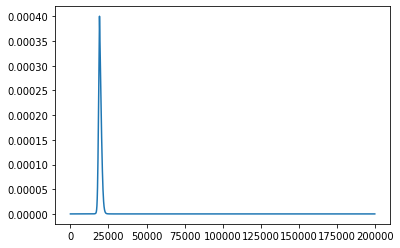

In [100]:
x = torch.Tensor(np.arange(0.001, 20 , 0.01)).to(device).unsqueeze(-1)
p = model(x) 
plt.plot(x.cpu().detach().numpy() * SCALING_CONSTANT, p.cpu().detach().numpy() / SCALING_CONSTANT)

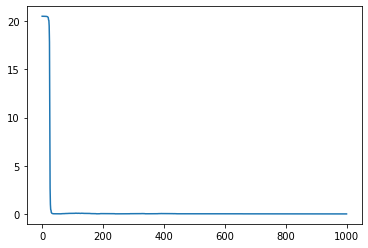

In [101]:
running_loss_average = uniform_filter1d(loss_history, size=50)
plt.plot(range(len(running_loss_average)), running_loss_average)

In [102]:
x = torch.Tensor(np.arange(0.001, 20, 0.01)).to(device).unsqueeze(-1)
p = np.array(model(x).detach())
print(np.argmax(p)*0.01*SCALING_CONSTANT)

19100.0
